In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
import scipy.stats as stats 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from statsmodels.formula.api import glm
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Data import and aggregation steps: 

    I.	Collate the information specific to flights, airports (like type of airport, elevation etc) and runway(length_ft, width_ft, surface etc.). Get all those fields in single dataset which you believe may impact the delay. 

In [2]:
airlines = pd.read_excel('Airlines.xlsx')
airports = pd.read_excel('airports.xlsx')
runways = pd.read_excel('runways.xlsx')

In [3]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
airports.head(2)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN


In [5]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


In [6]:
airports.head(2)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN


In [7]:
airport_run = pd.merge(airports, runways, left_on = 'ident', right_on = 'airport_ident', how = "left")
airport_run.head(2)

,id_x,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,...,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
count_runway = airport_run.groupby('airport_ident')[['id_y']].count().sort_values(by = 'id_y', ascending = False).reset_index()
count_runway.head(2)

,airport_ident,id_y
0,KORD,11
1,KNHU,10


In [9]:
air_run = pd.merge(airports, count_runway, how = 'left', left_on = 'ident', right_on = 'airport_ident')[['iata_code', 'type', 'elevation_ft','id_y']]
air_run.rename(columns = {'id_y': 'runway_count'}, inplace = True)
air_run.head(2)

,iata_code,type,elevation_ft,runway_count
0,NaN,heliport,11.0,1.0
1,NaN,small_airport,3435.0,NaN


In [10]:
air_run.dropna().to_csv('run_2.csv', index = False)

In [13]:
airlines.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1


In [11]:
combined_data = pd.merge(airlines, air_run, how = 'left', left_on = 'AirportFrom', right_on = 'iata_code')

new_names = list(combined_data[air_run.columns].columns + '_source_airport')
old_names = list(combined_data[air_run.columns].columns)

combined_data.rename(columns = {old:new for old,new in zip(old_names, new_names)}, inplace = True)
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0


In [12]:
combined_data.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'iata_code_source_airport',
       'type_source_airport', 'elevation_ft_source_airport',
       'runway_count_source_airport'],
      dtype='object')

In [13]:
combined_data = pd.merge(combined_data, air_run, how = 'left', left_on = 'AirportTo', right_on = 'iata_code')


In [14]:
new_names = list(combined_data[air_run.columns].columns + '_dest_airport')
old_names = list(combined_data[air_run.columns].columns)
combined_data.rename(columns = {old:new for old,new in zip(old_names, new_names)}, inplace = True)
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,iata_code_source_airport,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,iata_code_dest_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,SFO,large_airport,13.0,4.0,IAH,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,PHX,large_airport,1135.0,3.0,CLT,large_airport,748.0,4.0


In [15]:
# drop iata_code columns 
combined_data.drop(columns =  list(combined_data.columns[combined_data.columns.str.startswith('iata_code')]), inplace = True)

In [16]:
combined_data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0


In [17]:
test = pd.read_html("https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States")

In [18]:
len(test)

21

In [19]:
test[0]

,Airline,Image,IATA,ICAO,Callsign,"Primary hubs, secondary hubs",Founded,Notes
0,Alaska Airlines,NaN,AS,ASA,ALASKA,Seattle/Tacoma Anchorage Portland (OR) San Fra...,1932,Founded as McGee Airways and commenced operati...
1,Allegiant Air,NaN,G4,AAY,ALLEGIANT,Las Vegas Cincinnati Destin/Ft. Walton Beach I...,1997,Founded as WestJet Express and began operation...
2,American Airlines,NaN,AA,AAL,AMERICAN,Dallas/Fort Worth Charlotte Chicago–O'Hare Mia...,1926,Founded as American Airways and commenced oper...
3,Avelo Airlines,NaN,XP,VXP,AVELO,Burbank New Haven Orlando Raleigh/Durham Wilmi...,1987,First did business as Casino Express Airlines ...
4,Breeze Airways,NaN,MX,MXY,MOXY,Charleston (SC) Hartford New Orleans Norfolk P...,2018,Founded as Moxy Airways but was renamed due to...
5,Delta Air Lines,NaN,DL,DAL,DELTA,Atlanta Detroit Minneapolis/St. Paul New York–...,1924,Founded as Huff Daland Dusters and commenced o...
6,Eastern Airlines,NaN,2D,EAL,EASTERN,Miami,2010,NaN
7,Frontier Airlines,NaN,F9,FFT,FRONTIER FLIGHT,Denver Atlanta Chicago–O'Hare Cincinnati Cleve...,1994,NaN
8,Hawaiian Airlines,NaN,HA,HAL,HAWAIIAN,Honolulu Kahului,1929,Founded as Inter-Island Airways in early 1929 ...
9,JetBlue,NaN,B6,JBU,JETBLUE,New York–JFK Boston Los Angeles Fort Lauderdal...,1998,Founded as New Air and commenced operations in...


## II.	Different airline companies may perform differently in terms of on time arrival. The performance may depend on the experience of the airline company. Pull the information specific to different airlines from the Wikipedia page https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States. Use web scaping to fetch the information about how long the airlines has been in the business. 

In [21]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States').text
soup = BeautifulSoup(website_url,'lxml')
My_table = soup.findAll("table",{"class":"wikitable"})

In [22]:
len(My_table) 

7

In [23]:
airlines_wiki_list = []
for tab in My_table:
    temp = pd.read_html(str(tab))
    temp = pd.DataFrame(temp[0])
    airlines_wiki_list.append(temp)

In [24]:
airlines_wiki = pd.concat(airlines_wiki_list)

In [25]:
airlines_wiki.head(2)

,Airline,Image,IATA,ICAO,Callsign,"Primary hubs, secondary hubs",Founded,Notes
0,Alaska Airlines,NaN,AS,ASA,ALASKA,Seattle/Tacoma Anchorage Portland (OR) San Fra...,1932.0,Founded as McGee Airways and commenced operati...
1,Allegiant Air,NaN,G4,AAY,ALLEGIANT,Las Vegas Cincinnati Destin/Ft. Walton Beach I...,1997.0,Founded as WestJet Express and began operation...


III.	Get all the information pulled so far in one table.

In [26]:
combined_data.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0


### finding the year founded of airlines

In [27]:
airlines_founded = pd.merge(combined_data[['Airline']].drop_duplicates(),airlines_wiki[['IATA', 'Founded']].drop_duplicates(), 
         how = 'left', left_on = 'Airline', right_on = 'IATA')

In [28]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [ ]:
# will fill in missing values later

IV.	Look into Wikipedia page:
 https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States
Total passenger traffic may also contribute to the delay of flights. The term hub is used to identify busy commercial airports. Large hubs are the airports that each account for at least one percent of total U.S. passenger enplanements. Medium hubs are defined as airports that each account for between 0.25 percent and 1 percent of the total passenger enplanements.

Pull passenger traffic data using web scraping and collate in a table. 

In [29]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States').text
soup = BeautifulSoup(website_url,'lxml')
My_table = soup.findAll("table",{"class":"wikitable"})

In [30]:
hub_data = {}
i = 0
for tab in My_table:
    hub_data[i] = pd.read_html(str(tab))
    hub_data[i] = pd.DataFrame(hub_data[i][0])
    i +=1

## We need only hub data hence first two table

In [34]:
hub_data

{0:     Rank (2022)                                  Airports (large) IATA Code  \
 0             1  Hartsfield–Jackson Atlanta International Airport       ATL   
 1             2           Dallas/Fort Worth International Airport       DFW   
 2             3                      Denver International Airport       DEN   
 3             4                      O'Hare International Airport       ORD   
 4             5                 Los Angeles International Airport       LAX   
 5             6             John F. Kennedy International Airport       JFK   
 6             7                  Harry Reid International Airport       LAS   
 7             8                     Orlando International Airport       MCO   
 8             9                       Miami International Airport       MIA   
 9            10           Charlotte Douglas International Airport       CLT   
 10           11              Seattle–Tacoma International Airport       SEA   
 11           12          Phoenix Sky

In [35]:
large_hub = hub_data[0].copy()
med_hub = hub_data[1].copy()

In [36]:
large_hub.insert(loc =1, column= 'Hub_type', value = 'large')
med_hub.insert(loc =1, column= 'Hub_type', value = 'medium')

In [37]:
# before combinig lets work with column names 

In [38]:
# remove any special characters or things in bracket
large_hub.columns

Index(['Rank (2022)', 'Hub_type', 'Airports (large)', 'IATA Code',
       'Major cities served', 'Metro area', 'State', '2022[2]', '2021[3]',
       '2020[4]', '2019[5]', '2018[6]', '2017[7]', '2016[8]', '2015[9]',
       '2014[10]', '2013[11]'],
      dtype='object')

In [39]:
# remove refrences from brackets 
column_temp = large_hub.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
large_hub.columns = column_temp
large_hub.columns

Index(['rank', 'hub_type', 'airports', 'iata_code', 'major_cities_served',
       'metro_area', 'state', 'data_2022', 'data_2021', 'data_2020',
       'data_2019', 'data_2018', 'data_2017', 'data_2016', 'data_2015',
       'data_2014', 'data_2013'],
      dtype='object')

In [40]:
# remove refrences from brackets 
column_temp = med_hub.columns.str.split('[([]').str[0].str.strip().str.lower().str.replace(' ','_').values
column_temp[list(map( lambda x : x.isnumeric(), column_temp))]  = 'data_' + column_temp[list(map( lambda x : x.isnumeric(), column_temp))] 
med_hub.columns = column_temp
med_hub.columns

Index(['rank', 'hub_type', 'airports', 'iata_code', 'city_served',
       'metro_area', 'state', 'data_2022', 'data_2021', 'data_2020',
       'data_2019', 'data_2018', 'data_2017', 'data_2016', 'data_2015',
       'data_2014', 'data_2013'],
      dtype='object')

In [41]:
large_hub.rename(columns = {'major_cities_served':'city_served'}, inplace = True)

In [43]:
final_hub_data = pd.concat([large_hub, med_hub])

In [44]:
final_hub_data.head(2)

,rank,hub_type,airports,iata_code,city_served,metro_area,state,data_2022,data_2021,data_2020,data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,data_2013
0,1,large,Hartsfield–Jackson Atlanta International Airport,ATL,Atlanta,Atlanta,GA,45396001,36676010,20559866,53505795,51865797,50251964,50501858,49340732.0,46604273.0,45308407.0
1,2,large,Dallas/Fort Worth International Airport,DFW,Dallas and Fort Worth,Dallas–Fort Worth,TX,35345138,30005266,18593421,35778573,32821799,31816933,31283579,31589839.0,30804567.0,29038128.0


In [45]:
final_hub_data.data_2019.isnull().sum()

0

In [45]:
final_hub_data.isnull().sum()

rank           0
hub_type       0
airports       0
iata_code      0
city_served    0
metro_area     0
state          0
data_2022      0
data_2021      0
data_2020      0
data_2019      0
data_2018      0
data_2017      0
data_2016      0
data_2015      1
data_2014      1
data_2013      1
dtype: int64

In [47]:
final_hub_data.columns

Index(['rank', 'hub_type', 'airports', 'iata_code', 'city_served',
       'metro_area', 'state', 'data_2022', 'data_2021', 'data_2020',
       'data_2019', 'data_2018', 'data_2017', 'data_2016', 'data_2015',
       'data_2014', 'data_2013'],
      dtype='object')

In [46]:
combined_data_pax = pd.merge(combined_data, final_hub_data[['iata_code', 'data_2019']],how = 'left' , left_on = 'AirportFrom', right_on = 'iata_code')

In [47]:
combined_data_pax.rename(columns = {'iatacode': 'iatacode_source' ,'data_2019': 'data_2019_source_airport'}, inplace = True)

In [48]:
combined_data_pax = pd.merge(combined_data_pax, final_hub_data[['iata_code', 'data_2019']],how = 'left' , left_on = 'AirportTo', right_on = 'iata_code')

In [49]:
combined_data_pax.rename(columns = {'iata_code': 'iatacode_dest' ,'data_2019': 'data_2019_dest_airport'}, inplace = True)

In [50]:
combined_data_pax = combined_data_pax.loc[:,~combined_data_pax.columns.str.startswith('iatacode')].copy()

In [51]:
combined_data_pax

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0
1,2,US,1558,PHX,CLT,3,15,222,1,large_airport,1135.0,3.0,large_airport,748.0,4.0,PHX,22433552.0,CLT,24199688.0
2,3,AA,2400,LAX,DFW,3,20,165,1,large_airport,125.0,4.0,large_airport,607.0,7.0,LAX,42939104.0,DFW,35778573.0
3,4,AA,2466,SFO,DFW,3,20,195,1,large_airport,13.0,4.0,large_airport,607.0,7.0,SFO,27779230.0,DFW,35778573.0
4,5,AS,108,ANC,SEA,3,30,202,0,large_airport,152.0,3.0,large_airport,433.0,4.0,ANC,2713843.0,SEA,25001762.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518551,539377,B6,717,JFK,SJU,5,1439,220,1,large_airport,13.0,4.0,large_airport,9.0,2.0,JFK,31036655.0,SJU,4590117.0
518552,539378,B6,739,JFK,PSE,5,1439,223,1,large_airport,13.0,4.0,medium_airport,29.0,1.0,JFK,31036655.0,NaN,NaN
518553,539379,CO,178,OGG,SNA,5,1439,326,0,medium_airport,54.0,2.0,large_airport,56.0,2.0,OGG,3791807.0,SNA,5153276.0
518554,539382,UA,78,HNL,SFO,5,1439,313,1,large_airport,13.0,6.0,large_airport,13.0,4.0,HNL,9988678.0,SFO,27779230.0


## addd founded column

In [52]:
airlines_founded

,Airline,IATA,Founded
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,AA,1926.0
3,AS,AS,1932.0
4,DL,DL,1924.0
5,B6,B6,1998.0
6,HA,HA,1929.0
7,OO,OO,1972.0
8,9E,9E,1985.0
9,OH,OH,1979.0


In [53]:
combined_data_pax = pd.merge(combined_data_pax, airlines_founded[['Airline', 'Founded']], on = 'Airline')

In [54]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,NaN
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,NaN


## 1.	Check the missing values in each field. Perform missing value treatment. Justify your actions

### combined pax

In [56]:
combined_data_pax.shape

(518556, 20)

In [57]:
combined_data_pax.isna().sum().sort_values(ascending = False)

Founded                        83601
data_2019_source_airport       83586
iata_code_x                    83586
data_2019_dest_airport         83536
iata_code_y                    83536
runway_count_source_airport       31
runway_count_dest_airport         31
elevation_ft_dest_airport         31
type_dest_airport                 31
elevation_ft_source_airport       31
type_source_airport               31
Airline                            0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
id                                 0
dtype: int64

#### for type runway count and elevation lets get the airports for which information is missing

In [61]:
combined_data_pax[combined_data_pax.type_source_airport.isna()].AirportFrom.unique()

array(['CYS'], dtype=object)

In [62]:
combined_data_pax[combined_data_pax.type_dest_airport.isna()].AirportTo.unique()

array(['CYS'], dtype=object)

As we see information for only CYS is missing Lets check for this information using data dictionary and match the description and name of the airport to fetch information 

In [60]:
airport_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines',header = 29)
airport_dict.head(2)

,Aiport ID,Description,Unnamed: 2
0,ABE,RAF Calveley,NaN
1,ABE,Bisho Airport,NaN


In [61]:
airport_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines',header = 29, usecols = [0,1])
airport_dict.head(2)

,Aiport ID,Description
0,ABE,RAF Calveley
1,ABE,Bisho Airport


In [62]:
airport_dict[airport_dict['Aiport ID'] == 'CYS'].Description

194    Cheyenne Regional Jerry Olson Field
Name: Description, dtype: object

In [63]:
name = airport_dict[airport_dict['Aiport ID'] == 'CYS'].Description.values[0]
name.lower()

'cheyenne regional jerry olson field'

In [64]:
air_miss = airports.loc[name.lower() == airports.name.str.lower(), ['ident', 'name', 'iata_code', 'type', 'elevation_ft']]

In [65]:
air_miss.head(2)

,ident,name,iata_code,type,elevation_ft
34675,KCYS,Cheyenne Regional Jerry Olson Field,NaN,medium_airport,6159.0


In [66]:
air_miss_comb = pd.merge(air_miss, runways[['airport_ident', 'id']], how = 'left', left_on = 'ident', right_on = 'airport_ident')
runway_count_miss = air_miss_comb.groupby('ident')[['id']].count().sort_values(by = 'id', ascending = False).reset_index()
runway_count_miss

,ident,id
0,KCYS,2


In [68]:
air_miss_data = pd.merge(air_miss,runway_count_miss ).rename(columns = {'id' : 'runway_count'})[['iata_code', 'type', 'elevation_ft', 'runway_count']]

In [69]:
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'type_source_airport'] = air_miss_data.type.values[0]
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'elevation_ft_source_airport'] = air_miss_data.elevation_ft.values[0]
combined_data_pax.loc[combined_data_pax.AirportFrom == 'CYS', 'runway_count_source_airport'] = air_miss_data.runway_count.values[0]

In [70]:
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'type_dest_airport'] = air_miss_data.type.values[0]
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'elevation_ft_dest_airport'] = air_miss_data.elevation_ft.values[0]
combined_data_pax.loc[combined_data_pax.AirportTo == 'CYS', 'runway_count_dest_airport'] = air_miss_data.runway_count.values[0]

In [71]:
combined_data_pax.isna().sum().sort_values(ascending = False)

Founded                        83601
data_2019_source_airport       83586
iata_code_x                    83586
data_2019_dest_airport         83536
iata_code_y                    83536
Airline                            0
runway_count_dest_airport          0
elevation_ft_dest_airport          0
type_dest_airport                  0
runway_count_source_airport        0
id                                 0
type_source_airport                0
Delay                              0
Length                             0
Time                               0
DayOfWeek                          0
AirportTo                          0
AirportFrom                        0
Flight                             0
elevation_ft_source_airport        0
dtype: int64

In [72]:
airline_dict = pd.read_excel('Data Dictionary.xlsx', sheet_name = 'airlines',header = 10, usecols = [0,1])
airline_dict.head(2)

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta


In [76]:
miss_founded = combined_data_pax[combined_data_pax.Founded.isna()].Airline.unique()
print(airline_dict[airline_dict['Airlines ID'].isin( ['EV', 'CO', 'US'])])

  Airlines ID                        Description
5          US  PSA (initially US Airway Express)
7          EV                         ExpressJet
9          CO     United Airlines (initially CO)


In [77]:
miss_val = {'US' : 1967, 'CO' : 1934, 'EV' : 1986}
for aline in miss_founded:
    combined_data_pax.loc[(combined_data_pax.Founded.isna()) & 
                      (combined_data_pax.Airline == aline), 'Founded'] = miss_val[aline] 

In [78]:
(combined_data_pax.isna().sum().sort_values(ascending = False)/combined_data_pax.shape[0])*100

data_2019_source_airport       16.118992
iata_code_x                    16.118992
data_2019_dest_airport         16.109350
iata_code_y                    16.109350
id                              0.000000
Airline                         0.000000
runway_count_dest_airport       0.000000
elevation_ft_dest_airport       0.000000
type_dest_airport               0.000000
runway_count_source_airport     0.000000
elevation_ft_source_airport     0.000000
type_source_airport             0.000000
Delay                           0.000000
Length                          0.000000
Time                            0.000000
DayOfWeek                       0.000000
AirportTo                       0.000000
AirportFrom                     0.000000
Flight                          0.000000
Founded                         0.000000
dtype: float64

For missing pax data use median value based on 'type' of airport

In [79]:
combined_data_pax.groupby('type_source_airport')[['data_2019_source_airport']].median()

,data_2019_source_airport
type_source_airport,
large_airport,21905309.0
medium_airport,3323614.0
small_airport,NaN


In [80]:
med_val = combined_data_pax.groupby('type_source_airport')[['data_2019_source_airport']].median()
med_val

,data_2019_source_airport
type_source_airport,
large_airport,21905309.0
medium_airport,3323614.0
small_airport,NaN


In [81]:
for typ in combined_data_pax.type_source_airport.unique():
      combined_data_pax.loc[(combined_data_pax.type_source_airport == typ)& (combined_data_pax.data_2019_source_airport.isna()),
                      'data_2019_source_airport'] = med_val.loc[typ].values[0]

In [82]:
combined_data_pax.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'iata_code_x', 'data_2019_source_airport',
       'iata_code_y', 'data_2019_dest_airport', 'Founded'],
      dtype='object')

In [89]:
# med_val_dest = combined_data_pax.groupby('type_dest_airport')[['data_2019_dest_airport']].median()
# med_val_dest

In [83]:
for typ in combined_data_pax.type_source_airport.unique():
      combined_data_pax.loc[(combined_data_pax.type_dest_airport == typ)& (combined_data_pax.data_2019_dest_airport.isna()),
                      'data_2019_dest_airport'] = med_val.loc[typ].values[0]

In [84]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0


In [85]:
(combined_data_pax.isna().sum().sort_values(ascending = False)/combined_data_pax.shape[0])*100

iata_code_x                    16.118992
iata_code_y                    16.109350
data_2019_source_airport        0.226205
data_2019_dest_airport          0.224855
id                              0.000000
Airline                         0.000000
runway_count_dest_airport       0.000000
elevation_ft_dest_airport       0.000000
type_dest_airport               0.000000
runway_count_source_airport     0.000000
elevation_ft_source_airport     0.000000
type_source_airport             0.000000
Delay                           0.000000
Length                          0.000000
Time                            0.000000
DayOfWeek                       0.000000
AirportTo                       0.000000
AirportFrom                     0.000000
Flight                          0.000000
Founded                         0.000000
dtype: float64

### Since % of values missing is 0.2% we can simply eliminate these rows

## 2.	Perform data visualization and share your insights related to following aspects:
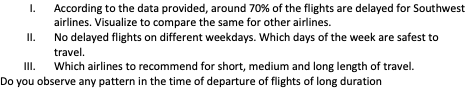

In [86]:
# get id for "southwest Airlines"
id_airline = airline_dict.loc[airline_dict['Description'].str.strip().str.lower() == 'southwest', 'Airlines ID'].values[0]

In [87]:
round(combined_data_pax[combined_data_pax.Airline == id_airline].Delay.sum()/
      combined_data_pax[combined_data_pax.Airline == id_airline].Delay.size*100)

70

In [88]:
def percent_Delay(x):
    return round(x.sum()/x.size * 100,2)

In [89]:
delay_perc = combined_data_pax.groupby('Airline')['Delay'].agg(percent_Delay)


In [90]:
delay_perc

Airline
9E    39.77
AA    38.85
AS    33.93
B6    46.70
CO    56.62
DL    45.05
EV    40.22
F9    44.90
HA    32.02
MQ    34.81
OH    27.73
OO    45.29
UA    32.39
US    33.60
WN    69.78
XE    37.89
YV    24.29
Name: Delay, dtype: float64

In [91]:
delay_perc = delay_perc.reset_index()

In [92]:
plot_data = pd.merge(delay_perc, airline_dict, left_on = 'Airline', 
                     right_on = 'Airlines ID', how = 'left')[['Airline', 'Description', 'Delay']]
plot_data

,Airline,Description,Delay
0,9E,Endeavor,39.77
1,AA,American Airlines,38.85
2,AS,Alaska,33.93
3,B6,Jetblue,46.70
4,CO,United Airlines (initially CO),56.62
5,DL,Delta,45.05
6,EV,ExpressJet,40.22
7,F9,Frontier,44.90
8,HA,Hawaiian,32.02
9,MQ,Envoy,34.81


findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font f

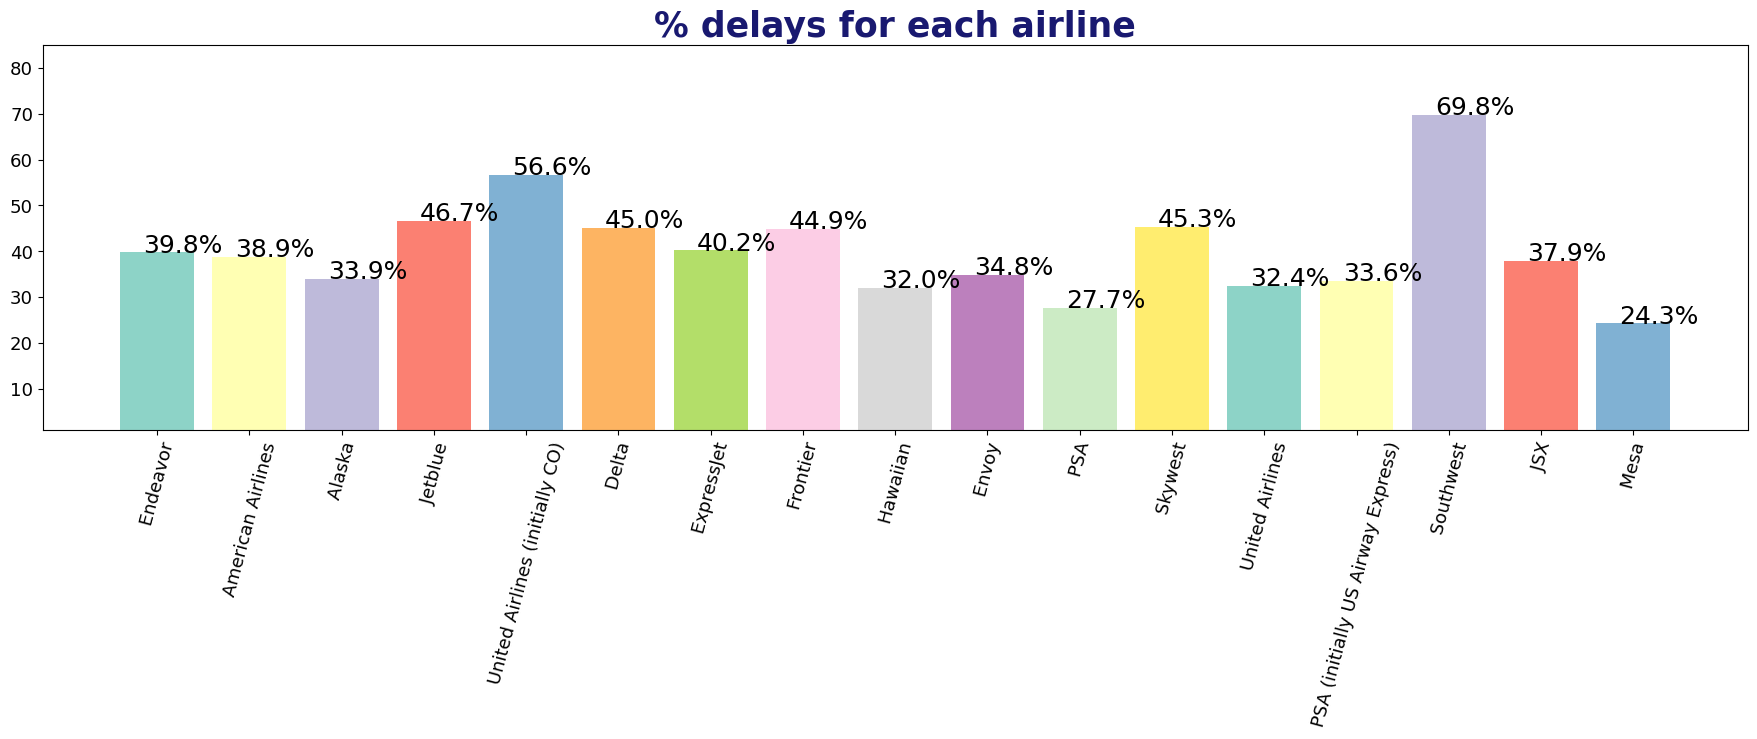

In [93]:
plt.figure(figsize = (22,5))
plt.bar(plot_data.Description, height =  plot_data.Delay, color = plt.get_cmap('Set3').colors)
for v, idx in zip(plot_data.Delay.values,plot_data.index ):
    plt.annotate('{:.1f}%'.format(v), xy = (idx-0.15, v), size = 18, family = 'times')
plt.ylim(1,85)
plt.xticks(size = 13, rotation = 75)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

## 
    II.	No delayed flights on different weekdays. Which days of the week are safest to travel.

In [94]:
combined_data_pax.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,152.0,3.0,large_airport,433.0,4.0,ANC,2713843.0,SEA,25001762.0,1934.0
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,2181.0,4.0,large_airport,97.0,5.0,LAS,24728361.0,IAH,21905309.0,1934.0
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,944.0,2.0,large_airport,97.0,5.0,ONT,2723002.0,IAH,21905309.0,1934.0


In [95]:
delay_perc_weekday = combined_data_pax.groupby('DayOfWeek')['Delay'].agg(percent_Delay)
delay_perc_weekday

DayOfWeek
1    47.22
2    45.21
3    47.58
4    45.78
5    42.56
6    40.56
7    45.77
Name: Delay, dtype: float64

findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font family 'times' not found.
findfont: Font f

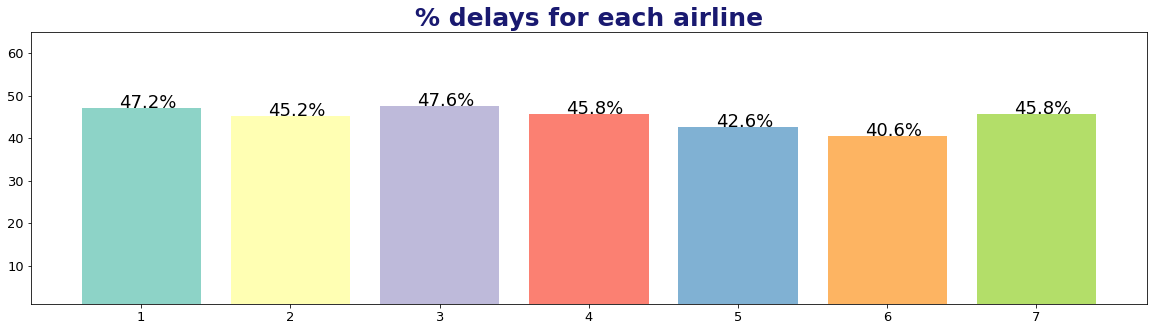

In [77]:
plt.figure(figsize = (20,5))
plt.bar(delay_perc_weekday.index, height =  delay_perc_weekday.values, color = plt.get_cmap('Set3').colors)
for v, idx in zip(delay_perc_weekday.values, range(1, len(delay_perc_weekday.index)+1)):
    # print(v, idx)
    plt.annotate('{:.1f}%'.format(v), xy = (idx-0.15, v), size = 18, family = 'times')
plt.ylim(1,65)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.title('% delays for each airline', size = 25, color = 'midnightblue', weight = 'heavy', family = 'times')
plt.show()

##
    III.	Which airlines to recommend for short, medium and long length of travel.

In [108]:
duration_data = combined_data_pax[['Airline', 'Length', 'Delay']].copy()

In [109]:
duration_data.head()

,Airline,Length,Delay
0,CO,205,1
1,CO,181,1
2,CO,201,1
3,CO,162,0
4,CO,167,0


In [110]:
duration_data['duration'] = pd.cut(duration_data.Length, 3, labels = ['short', 'medium', 'long'])


In [111]:
duration_data.head()

,Airline,Length,Delay,duration
0,CO,205,1,short
1,CO,181,1,short
2,CO,201,1,short
3,CO,162,0,short
4,CO,167,0,short


In [112]:
duration_data_grp = duration_data.groupby(['Airline','duration'])['Delay'].agg(
    percent_Delay).reset_index().pivot(index = 'Airline', 
                                       columns = 'duration').fillna(0)['Delay']
duration_data_grp.columns = duration_data_grp.columns.astype(str)
duration_data_grp.reset_index()

duration,Airline,short,medium,long
0,9E,39.77,0.00,0.00
1,AA,37.62,43.25,60.40
2,AS,32.58,38.17,0.00
3,B6,45.70,51.05,0.00
4,CO,52.88,64.96,66.87
5,DL,43.88,50.24,48.62
6,EV,40.22,50.00,0.00
7,F9,45.03,43.56,0.00
8,HA,30.16,40.48,0.00
9,MQ,34.82,27.42,0.00


In [113]:
duration_data.index

RangeIndex(start=0, stop=518556, step=1)

In [114]:
# get names of airlines also

In [115]:
airline_dict

,Airlines ID,Description
0,WN,Southwest
1,DL,Delta
2,OO,Skywest
3,AA,American Airlines
4,MQ,Envoy
...,...,...
683,XNA,Nambour Hospital Helipad
684,YAK,Aussenkehr Airport
685,YAK,Congo Town Airport
686,YAK,Yalkulka Airport


In [116]:
airline_dict.Description = airline_dict.Description.str.strip()
duration_data_grp = pd.merge(duration_data_grp,airline_dict[['Airlines ID', 'Description']],
         left_on = 'Airline', right_on = 'Airlines ID', 
         how = 'left')
duration_data_grp

,short,medium,long,Airlines ID,Description
0,39.77,0.00,0.00,9E,Endeavor
1,37.62,43.25,60.40,AA,American Airlines
2,32.58,38.17,0.00,AS,Alaska
3,45.70,51.05,0.00,B6,Jetblue
4,52.88,64.96,66.87,CO,United Airlines (initially CO)
5,43.88,50.24,48.62,DL,Delta
6,40.22,50.00,0.00,EV,ExpressJet
7,45.03,43.56,0.00,F9,Frontier
8,30.16,40.48,0.00,HA,Hawaiian
9,34.82,27.42,0.00,MQ,Envoy


In [117]:
combined_data_pax.Airline.nunique()

17

In [118]:
long = duration_data_grp[duration_data_grp.long == duration_data_grp.long.min()].Description.values.tolist()
print('Airlines with no delays for long flights :\n',', '.join(long))
medium = duration_data_grp[duration_data_grp.medium == duration_data_grp.medium.min()].Description.values.tolist()
print('\nAirlines with no delays for medium flights :\n', ', '.join(medium))
short = duration_data_grp[duration_data_grp.short == duration_data_grp.short.min()].Description.values.tolist()
print('\nAirlines with no delays for short flights :\n',  ', '.join(short)     )

Airlines with no delays for long flights :
 Endeavor, Alaska, Jetblue, ExpressJet, Frontier, Hawaiian, Envoy, PSA, Skywest, PSA (initially US Airway Express), Southwest, JSX, Mesa

Airlines with no delays for medium flights :
 Endeavor

Airlines with no delays for short flights :
 Mesa


## 
    IV.	Do you observe any pattern in the time of departure of flights of long duration

In [107]:
combined_data_pax['duration'] = pd.cut(combined_data_pax.Length, 3, labels = ['short', 'medium', 'long'])

In [108]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_x,data_2019_y,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,21905309.0,1934.0,short


In [109]:
pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long']

Time
10      0
15      0
20      0
21      0
25      0
       ..
1428    0
1430    0
1431    0
1435    0
1439    0
Name: long, Length: 1131, dtype: int64

In [110]:
y = pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long'].index
x = pd.crosstab(combined_data_pax.Time, combined_data_pax.duration)['long'].values

In [111]:
filter_data = combined_data_pax.loc[combined_data_pax.duration == 'long', ['Time', 'duration']]

In [112]:
filter_data.Time.describe()

count     559.000000
mean      840.635063
std       221.020092
min       540.000000
25%       670.000000
50%       717.000000
75%      1045.000000
max      1310.000000
Name: Time, dtype: float64

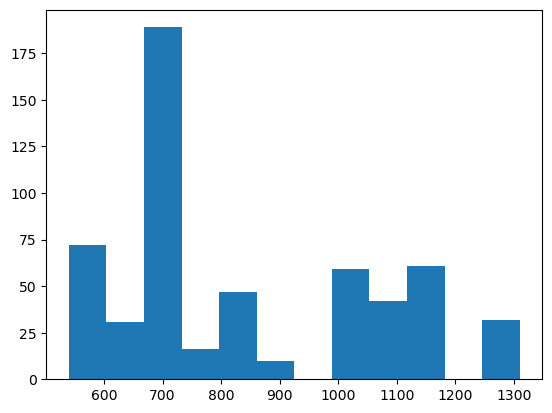

In [113]:
plt.hist(filter_data.Time, bins = 12)
plt.show()

## 3.	How Large Hubs compare to Medium hubs in terms of count of delayed flights. Use appropriate visualization to represent your findings.

In [93]:
combined_data_pax.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0,short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,...,3.0,large_airport,433.0,4.0,ANC,2713843.0,SEA,25001762.0,1934.0,short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,...,4.0,large_airport,97.0,5.0,LAS,24728361.0,IAH,21905309.0,1934.0,short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,...,2.0,large_airport,97.0,5.0,ONT,2723002.0,IAH,21905309.0,1934.0,short


<AxesSubplot: xlabel='type_source_airport'>

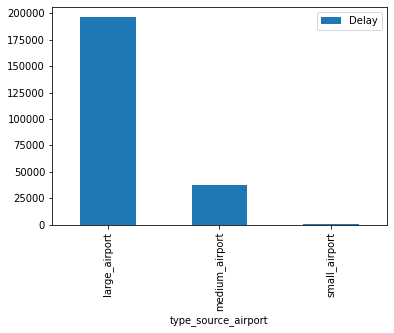

In [94]:
combined_data_pax.groupby('type_source_airport')[['Delay']].agg('sum').plot.bar()

<AxesSubplot: xlabel='type_dest_airport'>

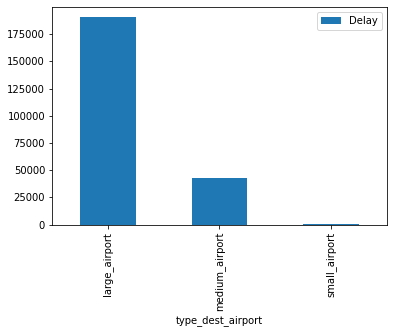

In [95]:
combined_data_pax.groupby('type_dest_airport')[['Delay']].agg('sum').plot.bar()

4.	Perform hypothesis testing techniques to learn:

    I.	Has the altitude of the airport anything to do with flight delays. Check for incoming and outgoing flights
    II.	Has surface-type of runways of airports anything to do with flight delays
    III.	 Has length, duration of flight, anything to do with flight delays


# I.	Has the altitude of the airport anything to do with flight delays. Check for incoming and outgoing flights

# 2 sample t test 

# for outgoing

In [96]:
sample1 = combined_data_pax[combined_data_pax.Delay == 1].elevation_ft_source_airport
sample2 = combined_data_pax[combined_data_pax.Delay == 0].elevation_ft_source_airport

In [97]:
t, p = stats.ttest_ind(sample1, sample2)

In [98]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'

In [99]:
result

'reject null'

## for incoming flights

In [100]:
sample1 = combined_data_pax[combined_data_pax.Delay == 1].elevation_ft_dest_airport
sample2 = combined_data_pax[combined_data_pax.Delay == 0].elevation_ft_dest_airport

In [101]:
t, p = stats.ttest_ind(sample1, sample2)

In [102]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'

In [103]:
result

'reject null'

## Conclusion : Significant difference in avg elevation wrt flight delay for both incoming and outgoing flights

## is no. of runway at airport for delayed < for non delayed 

In [104]:
combined_data_pax

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0,short
2,11,CO,223,ANC,SEA,3,49,201,1,large_airport,...,3.0,large_airport,433.0,4.0,ANC,2713843.0,SEA,25001762.0,1934.0,short
3,18,CO,1496,LAS,IAH,3,60,162,0,large_airport,...,4.0,large_airport,97.0,5.0,LAS,24728361.0,IAH,21905309.0,1934.0,short
4,20,CO,507,ONT,IAH,3,75,167,0,large_airport,...,2.0,large_airport,97.0,5.0,ONT,2723002.0,IAH,21905309.0,1934.0,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518551,538750,WN,2601,LAS,SMF,5,1230,85,1,large_airport,...,4.0,large_airport,27.0,2.0,LAS,24728361.0,SMF,6454413.0,1967.0,short
518552,538783,WN,1936,SMF,SAN,5,1235,85,1,large_airport,...,2.0,large_airport,17.0,1.0,SMF,6454413.0,SAN,12648692.0,1967.0,short
518553,538810,WN,2629,LAS,RNO,5,1240,75,1,large_airport,...,4.0,large_airport,4415.0,3.0,LAS,24728361.0,RNO,2162250.0,1967.0,short
518554,538833,WN,1226,SFO,LAX,5,1245,75,1,large_airport,...,4.0,large_airport,125.0,4.0,SFO,27779230.0,LAX,42939104.0,1967.0,short


In [105]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].runway_count_source_airport
s2 = combined_data_pax[combined_data_pax.Delay == 0].runway_count_source_airport

In [106]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [107]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].runway_count_dest_airport
s2 = combined_data_pax[combined_data_pax.Delay == 0].runway_count_dest_airport

In [108]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [109]:
combined_data_pax.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'iata_code_x', 'data_2019_source_airport',
       'iata_code_y', 'data_2019_dest_airport', 'Founded', 'duration'],
      dtype='object')

/tmp/ipykernel_71/2729550883.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matix = combined_data_pax.drop(columns = ['DayOfWeek', 'Time', 'Length', 'Delay','type_source_airport','type_dest_airport']).corr()


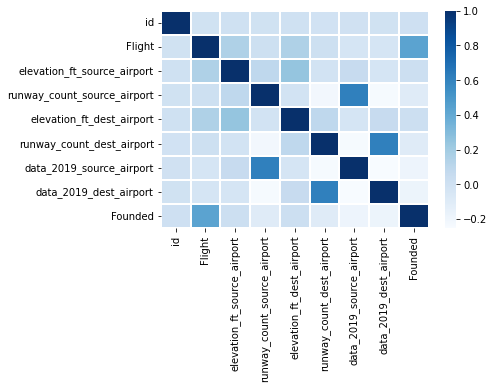

In [110]:
# Find correlation matrix amongst predictors of flight delay. Create a heatmap to visualize. Share your findings.

correlation_matix = combined_data_pax.drop(columns = ['DayOfWeek', 'Time', 'Length', 'Delay','type_source_airport','type_dest_airport']).corr()

sns.heatmap(correlation_matix, cmap='Blues',linecolor='white', linewidths=2)
plt.show()

## Conclusion : avg runway count at destination airport for delayed filghts < avg runway count at destination airport for delayed filghts for Incoming flights

## Has length, duration of flight, anything to do with flight delays!

In [111]:
s1 = combined_data_pax[combined_data_pax.Delay == 1].Length
s2 = combined_data_pax[combined_data_pax.Delay == 0].Length

In [112]:
t, p = stats.ttest_ind(s1, s2)

In [113]:
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [114]:
# there is isgnificant difference

In [115]:
cs = pd.crosstab(combined_data_pax.duration, combined_data_pax.Delay)
cs

Delay,0,1
duration,,
short,255324,204474
medium,28991,29208
long,252,307


In [116]:
chi, p, df, ex = stats.chi2_contingency(cs)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


In [117]:
t, p = stats.ttest_ind(s1, s2)
if p < 0.05:
    result = 'reject null'
else :
    result = 'fail to reject null'
print(result)

reject null


### Conclusion : avg duration for delayed filghts and non Delayed flights are significantly different.
        - avg duration of flights is less for non delayed flights
        - short duration flights get delayed less. 

## check info of dat

In [118]:
combined_data_pax.head(2)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,...,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded,duration
0,1,CO,269,SFO,IAH,3,15,205,1,large_airport,...,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0,short
1,6,CO,1094,LAX,IAH,3,30,181,1,large_airport,...,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0,short


In [119]:
combined_data_pax.columns

Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'type_source_airport',
       'elevation_ft_source_airport', 'runway_count_source_airport',
       'type_dest_airport', 'elevation_ft_dest_airport',
       'runway_count_dest_airport', 'iata_code_x', 'data_2019_source_airport',
       'iata_code_y', 'data_2019_dest_airport', 'Founded', 'duration'],
      dtype='object')

In [120]:
combined_data_pax.to_csv('combined_data_pax.csv', index=False)

## 6.	Use Onehotencoder and Ordinalencoder to deal with categorical variables.

In [121]:
combined_data_pax.isna().sum()

id                                 0
Airline                            0
Flight                             0
AirportFrom                        0
AirportTo                          0
DayOfWeek                          0
Time                               0
Length                             0
Delay                              0
type_source_airport                0
elevation_ft_source_airport        0
runway_count_source_airport        0
type_dest_airport                  0
elevation_ft_dest_airport          0
runway_count_dest_airport          0
iata_code_x                    85001
data_2019_source_airport        1173
iata_code_y                    84949
data_2019_dest_airport          1166
Founded                            0
duration                           0
dtype: int64

In [122]:
combined_data_pax.dropna(inplace = True)

In [123]:
combined_data_pax.drop(columns = ['id', 'Flight',  'duration'], inplace = True)

In [124]:
combined_data_pax.head(2)

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,iata_code_x,data_2019_source_airport,iata_code_y,data_2019_dest_airport,Founded
0,CO,SFO,IAH,3,15,205,1,large_airport,13.0,4.0,large_airport,97.0,5.0,SFO,27779230.0,IAH,21905309.0,1934.0
1,CO,LAX,IAH,3,30,181,1,large_airport,125.0,4.0,large_airport,97.0,5.0,LAX,42939104.0,IAH,21905309.0,1934.0


In [125]:
combined_data_pax.type_dest_airport.unique()

array(['large_airport', 'medium_airport'], dtype=object)

In [126]:
ordinal = OrdinalEncoder(categories=[['medium_airport', 'large_airport'],['medium_airport', 'large_airport']])
ordinal.fit(combined_data_pax[['type_source_airport', 'type_dest_airport']])

OrdinalEncoder(categories=[['medium_airport', 'large_airport'],
                           ['medium_airport', 'large_airport']])

In [127]:
combined_data_pax[['type_source_airport', 'type_dest_airport']] = ordinal.transform(combined_data_pax[['type_source_airport', 'type_dest_airport']])

In [128]:
model_data = combined_data_pax.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])

In [129]:
model_data.shape

(349772, 15)

In [130]:
dummy = pd.get_dummies(model_data)
dummy.shape

(349772, 141)

In [131]:
airlines.shape

(518556, 9)

In [132]:
dummy.Founded = 2022 - dummy.Founded

In [133]:
dummy.head(2)

,DayOfWeek,Time,Length,Delay,type_source_airport,elevation_ft_source_airport,runway_count_source_airport,type_dest_airport,elevation_ft_dest_airport,runway_count_dest_airport,...,iata_code_y_SAT,iata_code_y_SEA,iata_code_y_SFO,iata_code_y_SJC,iata_code_y_SJU,iata_code_y_SLC,iata_code_y_SMF,iata_code_y_SNA,iata_code_y_STL,iata_code_y_TPA
0,3,15,205,1,1.0,13.0,4.0,1.0,97.0,5.0,...,0,0,0,0,0,0,0,0,0,0
1,3,30,181,1,1.0,125.0,4.0,1.0,97.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
model_data.reset_index(drop = True, inplace = True)

In [135]:
np.random.seed(12)
deploy_idx = np.random.choice(model_data.index, replace = False, size = 5000)

In [136]:
deploy = model_data.loc[deploy_idx]

In [137]:
X_deploy = deploy.drop(columns = 'Delay')

In [138]:
model_dev = model_data.loc[~model_data.index.isin(deploy.index)]

In [139]:
deploy.reset_index(drop = True, inplace = True)
model_dev.reset_index(drop = True, inplace = True)

In [140]:
dummy.dropna(inplace=True)

In [141]:
X = dummy.drop(columns = 'Delay')
y = dummy.Delay

### Split data into train and test
### Standardise data


In [142]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [143]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=0)

In [144]:
st = StandardScaler()
x_train_std = st.fit_transform(x_train)
x_test_std = st.transform(x_test)

### Apply logistic regression (use stochastic gradient descent optimizer) and decision tree models


In [145]:
from sklearn.linear_model import SGDClassifier

In [146]:
sgdcModel = SGDClassifier()
sgdcModel.fit(x_train_std,y_train)

SGDClassifier()

In [147]:
# train score
sgdcModel.score(x_train_std,y_train)

0.5979476153989837

In [148]:
# train score
sgdcModel.score(x_test_std,y_test)

0.5984241162814633

### Accuracy report

In [149]:
from sklearn.metrics import classification_report

In [150]:
y_train_pred_sgd = sgdcModel.predict(x_train_std)
y_test_pred_sgd = sgdcModel.predict(x_test_std)

In [151]:
print(classification_report(y_train,y_train_pred_sgd))

print(classification_report(y_test,y_test_pred_sgd))

              precision    recall  f1-score   support

           0       0.60      0.67      0.64    137227
           1       0.59      0.52      0.55    125102

    accuracy                           0.60    262329
   macro avg       0.60      0.59      0.59    262329
weighted avg       0.60      0.60      0.60    262329

              precision    recall  f1-score   support

           0       0.60      0.67      0.64     45743
           1       0.59      0.52      0.55     41700

    accuracy                           0.60     87443
   macro avg       0.60      0.59      0.59     87443
weighted avg       0.60      0.60      0.60     87443



### Decision Tree Model

In [152]:
from sklearn.tree import DecisionTreeClassifier

In [153]:
dtModel = DecisionTreeClassifier()

dtModel.fit(x_train,y_train)

# train Score
dtModel.score(x_train,y_train)

#test score
dtModel.score(x_test,y_test)

y_train_pred_dt = dtModel.predict(x_train)
y_test_pred_dt = dtModel.predict(x_test)

print(classification_report(y_train,y_train_pred_dt))

print(classification_report(y_test,y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85    137227
           1       0.90      0.71      0.79    125102

    accuracy                           0.82    262329
   macro avg       0.84      0.82      0.82    262329
weighted avg       0.84      0.82      0.82    262329

              precision    recall  f1-score   support

           0       0.61      0.70      0.65     45743
           1       0.60      0.50      0.55     41700

    accuracy                           0.60     87443
   macro avg       0.60      0.60      0.60     87443
weighted avg       0.60      0.60      0.60     87443



### Decision tree is overfitted

In [154]:
dtModel = DecisionTreeClassifier(min_samples_split=12,min_samples_leaf=12) # try different values 

dtModel.fit(x_train,y_train)

# train Score
dtModel.score(x_train,y_train)

#test score
dtModel.score(x_test,y_test)

y_train_pred_dt = dtModel.predict(x_train)
y_test_pred_dt = dtModel.predict(x_test)

print(classification_report(y_train,y_train_pred_dt))

print(classification_report(y_test,y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.72      0.79      0.75    137227
           1       0.74      0.67      0.70    125102

    accuracy                           0.73    262329
   macro avg       0.73      0.73      0.73    262329
weighted avg       0.73      0.73      0.73    262329

              precision    recall  f1-score   support

           0       0.65      0.70      0.67     45743
           1       0.64      0.58      0.61     41700

    accuracy                           0.64     87443
   macro avg       0.64      0.64      0.64     87443
weighted avg       0.64      0.64      0.64     87443



In [155]:
from sklearn.ensemble import GradientBoostingRegressor

In [156]:
gbmodel = GradientBoostingRegressor()
gbmodel.fit(x_train,y_train)

GradientBoostingRegressor()

In [157]:
print(gbmodel.feature_importances_)

[1.56380565e-02 2.99486898e-01 4.01268392e-02 0.00000000e+00
 1.84954034e-02 2.41557682e-02 0.00000000e+00 8.72237069e-03
 3.77336530e-03 1.85768628e-02 5.03400046e-03 4.02016537e-01
 0.00000000e+00 0.00000000e+00 1.15823037e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.67197363e-04
 0.00000000e+00 1.99087674e-03 0.00000000e+00 7.67567565e-05
 1.23645493e-02 0.00000000e+00 0.00000000e+00 1.51649888e-03
 9.69921881e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.81862351e-04 3.52066492e-04
 0.00000000e+00 1.67387780e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.90580081e-03 0.00000000e+00 2.95469193e-03
 0.00000000e+00 0.00000000e+00 2.26044321e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.13229642e-03 1.45307761e-03 0.00000000e+00 0.00000000e+00
 3.53111876e-03 0.00000000e+00 0.00000000e+00 7.89199788e-03
 7.77901365e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.56256481e-04 0.000000

In [158]:
pd.DataFrame({'Features':gbmodel.feature_names_in_,'Importance':gbmodel.feature_importances_}).sort_values("Importance",ascending=False)

,Features,Importance
11,Founded,0.402017
1,Time,0.299487
2,Length,0.040127
88,iata_code_y_CLT,0.024325
5,runway_count_source_airport,0.024156
...,...,...
55,iata_code_x_ONT,0.000000
54,iata_code_x_OMA,0.000000
51,iata_code_x_MSY,0.000000
50,iata_code_x_MSP,0.000000


In [159]:
gbmodel.score(x_train,y_train)

0.10945666158862555

In [160]:
gbmodel.score(x_test,y_test)

0.10417735013457807